Traditional feature engeering strategies for textual data (BoW) models:

- TF-IDF (term fequency-inverse document frequency)
- N-grams
- topic modelling

In [1]:
import re
import pandas as pd
import numpy as np
import spacy
import nltk

2023-05-30 11:15:01.918229: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 11:15:02.546922: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-30 11:15:03.317274: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-30 11:15:03.334043: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [16]:
from nltk.stem import WordNetLemmatizer
from collections import Counter

wn = WordNetLemmatizer()

resume = pd.read_csv("archive/Resume/Resume.csv")
resume = resume.reindex(np.random.permutation(resume.index))
resume.head()


def clean_text(text):
    text = re.sub(r'httpS+s*', ' ', text)
    # remove new line chracters
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\xa0', '', text)
    text = re.sub(r'\t', '', text)
    # remove punctuations (words and whitespaces only)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r' +', ' ', text)
    # we do bag of words first
    bow = text.split(" ")

    # remove stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    words_d = [wn.lemmatize(x) for x in list(set(bow).difference(set(stopwords)))]
    
    return set(words_d)

finalset = set()

for r in resume.Resume_str:
    res = clean_text(r)
    reskeys = dict.fromkeys(res, 1)
    finalset = dict(Counter(reskeys) + Counter(finalset))


In [17]:
len(finalset)

73130

In [48]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
stopwords = nltk.corpus.stopwords.words('english')
def tokenize(input_doc):
    tokens = []
    wn = WordNetLemmatizer()
    cptoken = [wn.lemmatize(x).lower() for x in word_tokenize(input_doc) if x not in stopwords and \
                 not x.isnumeric() and x.isalpha() and len(x) >= 2]
        
    return cptoken

## TF-IDF Model

### Term Frequency (TF)
Raw frequency value of that term in a particular document.

${tf(w,D) = f_wD}$

where ${f_wD}$ denote frequency for **word** ${w}$ in document ${D}$, the number of times a word appears in adocument divided by total number of words in the document.]]

${tf_{i,j}}$ = ${n_{i,j}\over\sum_k n_{i,j}}$

### Inverse Document Frequency (IDF)
The Inverse Document Frequency measures how important a term is, weighing down the ferquent terms while scale up the rare ones.

the IDF is log of **N** total number of doucments in corpus divided by number oif documents a token occurs

${idf(w)}$ = ${\log({N \over{df_t}})}$

In [8]:
def inverted_index(words):
    """
        An ivnerted index of words (given word, find docID and idx)
    """
    inverted = {}
    for idx, word in enumerate(words):
        loc = inverted.setdefault(word, [])
        loc.append(idx)
    return inverted

def inverted_index_add(inverted, docID, doc_idx):
    for word in doc_idx.keys():
        loc = doc_idx[word]
        indices = inverted.setdefault(word, {})
        indices[docID] = loc
        
    return inverted

In [84]:
import re
import pandas as pd
import numpy as np
from tqdm import tqdm

import spacy
import nltk
from nltk.stem import WordNetLemmatizer
from collections import Counter
wn = WordNetLemmatizer()

resume = pd.read_csv("archive/Resume/Resume.csv")
resume = resume.reindex(np.random.permutation(resume.index))
resume.head()

,ID,Resume_str,Resume_html,Category
1930,29087505,CONSTRUCTION WORK Career Over...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION
281,37242217,INFORMATION TECHNOLOGY CONSULTANT ...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY
351,34745915,TEACHER Professional Summary ...,"<div class=""fontsize fontface vmargins hmargin...",TEACHER
475,74126637,BILINGUAL CLIENT ADVOCATE Profe...,"<div class=""fontsize fontface vmargins hmargin...",ADVOCATE
1066,92200491,SALES REPRESENTATIVE Summary ...,"<div class=""fontsize fontface vmargins hmargin...",SALES


In [49]:
corpus = resume.Resume_str
inverted_doc_idx = {}
word_corpus = {}
with tqdm(total=len(corpus)) as pbar:
    for docid, x in enumerate(corpus):
        words = tokenize(x)
        word_corpus[docid] = words
        inv_idx = inverted_index(words)
        inverted_index_add(inverted_doc_idx, docid, inv_idx)
        pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████| 2484/2484 [00:14<00:00, 171.28it/s]


In [50]:
# occurence of the word admin in each doc and its location
sample_idd = inverted_doc_idx['admin']
docid = list(sample_idd.keys())[0]
keyid = sample_idd[list(sample_idd.keys())[0]][0]
assert word_corpus[docid][keyid] == "admin"

In [105]:
data_frequency = {}
for word in inverted_doc_idx.keys():
    # number of docs that the word apepar in
    data_frequency[word] = len(list(inverted_doc_idx[word].keys()))
    
total_vocab_size = len(data_frequency)

print(f"total words: {total_vocab_size}")

total words: 34893


In [106]:
len(inverted_doc_idx.keys())

34893

## TF-IDF Matrix
Now, we generate the document-term matrix with Tf-idf as its weight.

In [126]:
import math
tfidf_mat = {}
for docid, token in tqdm(word_corpus.items()):
    count = Counter(token)
    words_count = len(token)
    for word in list(count.keys()):
        #Calculate Term Frequency
        # frequency for the number of times a word appears in a document/total number of words in the document
        tf = count[word] / float(words_count)
        # the IDF is log(**N** total number of doucments in corpus)/ number of documents a token occurs
        idf = math.log(len(word_corpus)/ len(inverted_doc_idx[word].keys()))
        tfidf = tf * idf
        if tfidf > 1.0 or tfidf < 0.0:
            print(f"[WARNING TFIDF score out of scope [0-1.0]. tf: {tf}, idf: {idf}. tfidf: {tfidf}")
            break
        tfidf_mat[docid, word] = tfidf

100%|███████████████████████████████████████████████████████████████████████████| 2484/2484 [00:00<00:00, 3416.53it/s]


In [107]:
# import math
# tfidf_mat = {}
# N = len(word_corpus)

# for docid, token in tqdm(word_corpus.items()):
#     count = Counter(token)
#     words_count = len(token)
#     for word in list(count.keys()):
#         #Calculate Term Frequency
#         # frequency for the number of times a word appears in a document/total number of words in the document
#         tf = count[word]
#         tf = 1 + np.log(tf)
        
#         # the IDF is log(**N** total number of doucments in corpus)/ number of documents a token occurs
#         df = data_frequency[word] if word in data_frequency else 0
#         idf = np.log((N+1)/(df+1))
#         tfidf = tf*idf
        
#         # if tfidf > 1.0 or tfidf < 0.0:
#         #     print(f"[WARNING TFIDF score out of scope [0-1.0]. tf: {tf}, idf: {idf}. ")
#         #     break
#         tfidf_mat[docid, word] = tfidf

100%|███████████████████████████████████████████████████████████████████████████| 2484/2484 [00:02<00:00, 1123.85it/s]


In [71]:
inverted_doc_idx['public']

{0: [0, 45, 308, 553],
 1: [304, 616, 1024],
 3: [19, 64, 314, 564, 610],
 4: [1, 10, 43, 52, 66, 120, 292, 298, 363, 382, 551, 627, 662, 695, 713, 747],
 5: [454],
 10: [61],
 14: [218, 336],
 18: [12, 28, 100, 231, 864],
 19: [326, 334],
 25: [241, 615],
 28: [243, 277],
 29: [397, 402],
 35: [47],
 40: [27],
 43: [651],
 45: [7, 34],
 46: [27, 49, 209, 262, 420, 521],
 59: [180],
 60: [0, 5, 24, 41, 239, 368, 477, 491],
 70: [257, 459],
 73: [89],
 75: [8, 322],
 79: [19],
 80: [20, 398, 442, 511],
 81: [258],
 82: [858],
 90: [422, 439],
 91: [62],
 95: [344],
 96: [141, 150],
 97: [328, 531],
 104: [334],
 106: [283],
 110: [220, 838],
 114: [0, 344, 457],
 121: [171, 173, 198, 200, 225, 227, 252, 254],
 122: [1, 55, 91, 481],
 129: [198],
 146: [339],
 149: [3, 5, 644],
 153: [70, 490, 970, 1153],
 155: [651],
 160: [0,
  48,
  132,
  153,
  170,
  188,
  226,
  242,
  257,
  295,
  379,
  512,
  549,
  559,
  577,
  603],
 161: [245, 417, 421, 489],
 165: [202],
 167: [29],
 175

## Search given TFIDF Matrix

In [139]:
# Make sure you run the above to get your tfidf mat first as we refer it internally
def ranked_search(query, firstx=10):
    tokens = tokenize(query)
    query_weights = {}
    # get all the weights of the documents in which the term existed
    #get documents that matches the key
    for mapword, wmap in inverted_doc_idx.items():
        appear_in_docs = list(wmap.keys())

        if mapword in tokens:
            # print(f"looking via: {tokens}")
            # print(f"found {mapword} in tokens for docs {appear_in_docs}")
            for docid in appear_in_docs:
                # we add the value onto that doc id. The more words scored for that doc, the heavier the weight
                query_weights[docid] = query_weights.get(docid,0) + tfidf_mat[docid, mapword]
                
    query_weights = sorted(query_weights.items(), key=lambda x:x[1], reverse=True)[:firstx]
    result = []
    for (docid, tfidfval) in query_weights:
        data = {
                    'Relevance': round(tfidfval*100,2),
                    'ID': docid, 
                    'Resume_str': resume.Resume_str.iloc[docid], 
                    'Category': resume.Category[docid]
                }
        result.append(data)
    result = pd.DataFrame(result)
    return result

In [128]:
tfidf_mat[1758, "teacher"]

0.09787001650882389

In [140]:
res = ranked_search("HR")
res.head()

,Relevance,ID,Resume_str,Category
0,8.48,378,APPAREL PRODUCTION MANAGER Exec...,TEACHER
1,8.12,578,INFORMATION TECHNOLOGY AND AWS ADMIN ...,BUSINESS-DEVELOPMENT
2,7.94,1059,FINANCE AND SALES CONSULTANT ...,SALES
3,7.58,64,REHABILITATION SPECIALIST / MASSAGE T...,HR
4,7.44,1163,TEACHER Professional Summary ...,CONSULTANT


In [166]:
from functools import reduce

## Using AND as logical operator. If there are multiple terms, they all must exist in that document
def boolean_search(query, firstx=10):
    """Run a boolean search with AND operator between terms over 
    the inverted index.
   """      
    # preprocess the user query using same function used to build Inverted Index
    words = [x for x in tokenize(query) if x in list(inverted_doc_idx.keys())]
    results = []
    for w in words:
        docs = inverted_doc_idx[w]
        results.append(set(docs.keys()))
    # AND operator. Replace & for | to modify to OR behavior.
    docs = reduce(lambda x, y: x & y, results) if results else []
    docidx = list(docs)[:firstx]
    result = []
    for docid in docidx:
        data = {
                    'ID': docid, 
                    'Resume_str': resume.Resume_str.iloc[docid], 
                    'Category': resume.Category[docid]
                }
        result.append(data)
    result = pd.DataFrame(result)
    return result

In [165]:
res = boolean_search("HR IT")
res.head()

,ID,Resume_str,Category
0,897,SENIOR LEAD TECHNOLOGIST EDITOR ...,FITNESS
1,1018,HR ANALYST Summary Experi...,SALES
2,2309,SENIOR FINANCE MANAGER Summ...,ARTS
3,1544,EXECUTIVE CHEF-PARTNER Summ...,FINANCE
4,396,ADMINISTRATION ASSISTANT Prof...,TEACHER


## Old implementation

In [46]:
totalworddict = sum([Counter(x) for x in worddict], Counter())
len(totalworddict)
def compute_term_frequency(worddict, bow, inv_word_freq):
    tfidf = {}
    
    for word in worddict:
        count = bow[word]
        term_frequency[word] = count / float(len(worddict))
        #print(f"{word}: {term_frequency[word]}")
        tfidf[word] = term_frequency[word]*inv_word_freq[word]
        #print(f"TFIDF {word}: {tfidf[word]}")
    return tfidf
        
# now, we calculat the inverse term. We need to find out the number of times this word
# appears in a doc and how many
def compute_doc_frequency(worddict, bow):
    word_doc_freq = {}

    # combine it into a big worddict
    totalworddict = sum([Counter(x) for x in worddict], Counter())
   
    for word in totalworddict:
        k = 0
        for i in range(len(worddict)):
            if word in bow[i]:
                k += 1
                break
                
        if k == 0:
            # does not appear in any dict?
            print(totalworddict[word])
        inv_freq = math.log(len(worddict[i])/k)
        word_doc_freq[word] = inv_freq
    return word_doc_freq

In [47]:
import math
#compute term frequency
term_frequency = {}
bow_len = len(bow)
totalworddict = sum([Counter(x) for x in worddict], Counter())
word_doc_freq = compute_doc_frequency(worddict, bow)

# tfidf of words for document index 0
tfidf_i = compute_term_frequency(worddict[0], bow[0], word_doc_freq)
tfidf_i

{'ASSISTANT': 0.009900206466618705,
 'BANKING': 0.009900206466618705,
 'CENTER': 0.009900206466618705,
 'MANAGER': 0.009900206466618705,
 'I': 0.01980041293323741,
 'Summary': 0.009900206466618705,
 'Experienced': 0.03960082586647482,
 'Signals': 0.009900206466618705,
 'analysis': 0.09900206466618705,
 'GeoSpatial': 0.009900206466618705,
 'Electronic': 0.009900206466618705,
 'Warfare': 0.009900206466618705,
 'Networks': 0.029700619399856115,
 'Threat': 0.009900206466618705,
 'DNR': 0.009900206466618705,
 'Limited': 0.009900206466618705,
 'knowledge': 0.049501032333093525,
 'performing': 0.009900206466618705,
 'DNI': 0.009900206466618705,
 'Basic': 0.029700619399856115,
 'computer': 0.009900206466618705,
 'network': 0.009900206466618705,
 'applications': 0.01980041293323741,
 'World': 0.009900206466618705,
 'Wide': 0.01980041293323741,
 'Web': 0.009900206466618705,
 'printers': 0.009900206466618705,
 'email': 0.009900206466618705,
 'instant': 0.009900206466618705,
 'messaging': 0.009900

In [50]:
tfidf_i

{'ASSISTANT': 0.009900206466618705,
 'BANKING': 0.009900206466618705,
 'CENTER': 0.009900206466618705,
 'MANAGER': 0.009900206466618705,
 'I': 0.01980041293323741,
 'Summary': 0.009900206466618705,
 'Experienced': 0.03960082586647482,
 'Signals': 0.009900206466618705,
 'analysis': 0.09900206466618705,
 'GeoSpatial': 0.009900206466618705,
 'Electronic': 0.009900206466618705,
 'Warfare': 0.009900206466618705,
 'Networks': 0.029700619399856115,
 'Threat': 0.009900206466618705,
 'DNR': 0.009900206466618705,
 'Limited': 0.009900206466618705,
 'knowledge': 0.049501032333093525,
 'performing': 0.009900206466618705,
 'DNI': 0.009900206466618705,
 'Basic': 0.029700619399856115,
 'computer': 0.009900206466618705,
 'network': 0.009900206466618705,
 'applications': 0.01980041293323741,
 'World': 0.009900206466618705,
 'Wide': 0.01980041293323741,
 'Web': 0.009900206466618705,
 'printers': 0.009900206466618705,
 'email': 0.009900206466618705,
 'instant': 0.009900206466618705,
 'messaging': 0.009900

In [14]:
!pip install plotly[all]
!pip install jupyter-dash

/bin/bash: /home/arielg/anaconda3/envs/aistack/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/arielg/anaconda3/envs/aistack/lib/libtinfo.so.6: no version information available (required by /bin/bash)


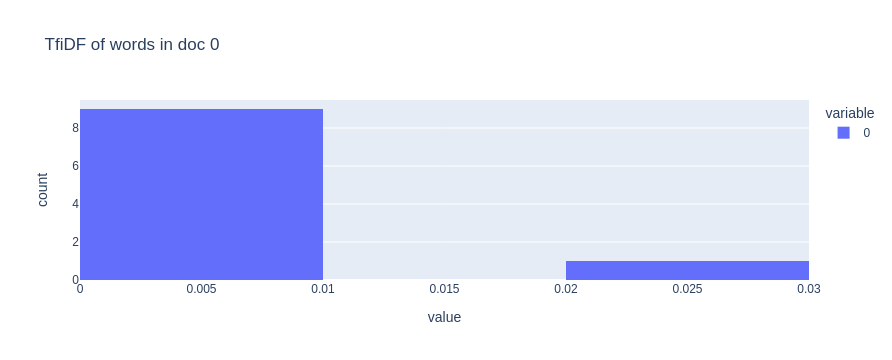

In [34]:
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
plotly.offline.init_notebook_mode(connected=True)

data = pd.DataFrame.from_dict(tfidf_i, orient='index')
fig = px.histogram(
                data[:10],
                title="TfiDF of words in doc 0"
        )#.update_xaxes(categoryorder="total descending")
fig.show()

In [36]:
!pip install wordcloud

/bin/bash: /home/arielg/anaconda3/envs/aistack/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.1/473.1 kB 5.8 MB/s eta 0:00:00m eta 0:00:010:00:01


In [44]:
data[:100]

,0
ASSISTANT,0.002457
BANKING,0.002457
CENTER,0.002457
MANAGER,0.002457
I,0.004914
...,...
suite,0.002457
Belleview,0.002457
Metrics,0.002457
Anchory,0.002457


In [41]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

sdata = data.squeeze(axis=0)
series = pd.Series(sdata)
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)

plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


ValueError: We need at least 1 word to plot a word cloud, got 0.